# Notebook Import

In [1]:
from os import walk
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import gutenberg
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split


%matplotlib inline

# Constants

In [2]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

DATA_JSON_FILE= 'SpamData/01_Processing/email-text-data.json'
DATA_ID_FILE='SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'
VOCAB_SIZE = 2500

SPAM_CAT = 1
HAM_CAT = 0

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading file

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1',)
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [4]:
import sys

sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

body_message = []
is_body = False

for line in stream:    
    if is_body:
        body_message.append(line)
    elif line == '\n':
        is_body = True
        
stream.close()
email_body = '\n'.join(body_message)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Function

In [6]:
def generate_square(N):
    for num in range(N):
        yield num**2 

In [7]:
for i in generate_square(5):
    print(i, end=' --> ')

0 --> 1 --> 4 --> 9 --> 16 --> 

# Email body extraction

In [8]:
def email_body_generator(path):   

    for root, dirnames, filenames in walk(path):

        for file_name in filenames:        

            file_path = join(root, file_name)
            stream = open(file_path, encoding='latin-1')
            body_message = []
            is_body = False

            for line in stream:    
                if is_body:
                    body_message.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()
            email_body = '\n'.join(body_message)

            yield file_name, email_body   

In [9]:
def df_from_directory(path, classification):
    rows = []
    rows_name = []
    for file_name, email_body in email_body_generator(path):
        rows.append({'CATEGORY': classification, 'MESSAGE': email_body})
        rows_name.append(file_name)
    return pd.DataFrame(rows, index=rows_name)    

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = pd.concat([spam_emails, df_from_directory(SPAM_2_PATH, SPAM_CAT)], axis=0)
spam_emails.head()

,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = pd.concat([ham_emails, df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)], axis=0)
ham_emails.head()

,CATEGORY,MESSAGE
00001.7c53336b37003a9286aba55d2945844c,0,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
00002.9c4069e25e1ef370c078db7ee85ff9ac,0,"Martin A posted:\n\nTassos Papadopoulos, the G..."
00003.860e3c3cee1b42ead714c5c874fe25f7,0,Man Threatens Explosion In Moscow \n\n\n\nThur...
00004.864220c5b6930b209cc287c361c99af1,0,Klez: The Virus That Won't Die\n\n \n\nAlready...
00005.bf27cdeaf0b8c4647ecd61b1d09da613,0,"> in adding cream to spaghetti carbonara, whi..."


In [13]:
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [15]:
data.tail()

,CATEGORY,MESSAGE
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."
01400.f897f0931e461e7b2e964d28e927c35e,0,"Hi there,\n\n\n\nNow this is probably of no us..."


# Data Cleaning: checking for missing values

In [16]:
data['MESSAGE'].isnull().sum()

0

In [17]:
(data.MESSAGE.str.len() == 0).sum()

3

## Locate empty emails

In [18]:
data[data.MESSAGE.str.len() == 0]

,CATEGORY,MESSAGE
cmds,1,
cmds,1,
cmds,0,


In [19]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [20]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

In [21]:
data.loc['cmds']

,CATEGORY,MESSAGE
cmds,1,
cmds,1,
cmds,0,


## Remove System File Entries from Dataframe

In [22]:
data.drop(labels=['cmds'], inplace=True)

In [23]:
(data.MESSAGE.str.len()==0).sum()

0

In [24]:
data[data.MESSAGE.str.len()==0]

,CATEGORY,MESSAGE


## Add Document IDs to Track Emails in Dataset

In [25]:
doc_ID = range(0, len(data.MESSAGE))
data['DOC_ID'] = doc_ID

In [26]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)

In [27]:
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


# Save to File using Pandas

In [28]:
data.to_json(DATA_JSON_FILE)

# Data Visualisation

## Number of Spam Messages Visualised (Pie Charts)

In [29]:
data['CATEGORY'].value_counts()

CATEGORY
0    3900
1    1896
Name: count, dtype: int64

In [30]:
sizes = [data['CATEGORY'].value_counts()[0], data['CATEGORY'].value_counts()[1]]
labels = ['Logit email', 'Spam']

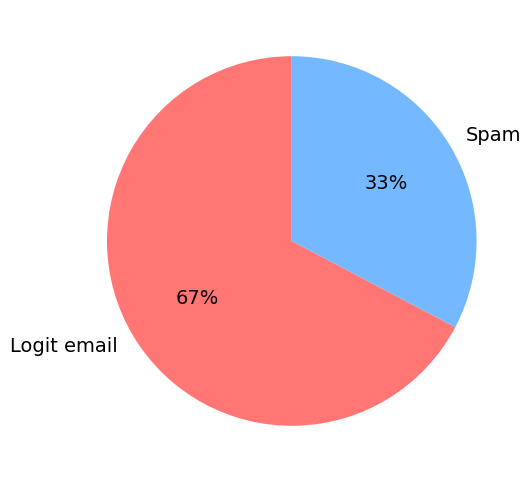

In [31]:
plt.figure(figsize=(9,6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors=['#ff7675', '#74b9ff'], startangle=90, textprops={'fontsize':14})
plt.show()

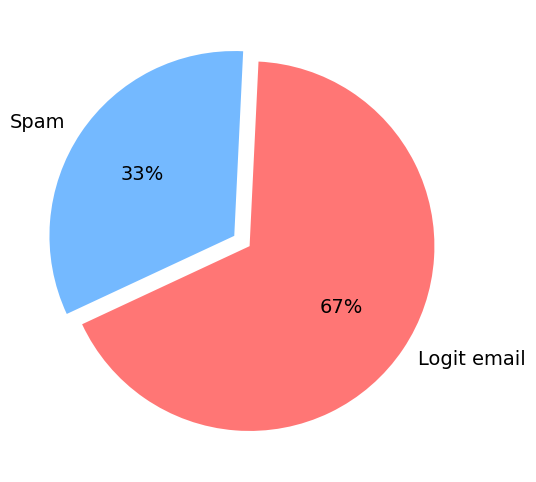

In [32]:
explode = (0.05, 0.05)

plt.figure(figsize=(8,6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors=['#ff7675', '#74b9ff'], 
        startangle=205, textprops={'fontsize':14}, explode=explode)
plt.show()

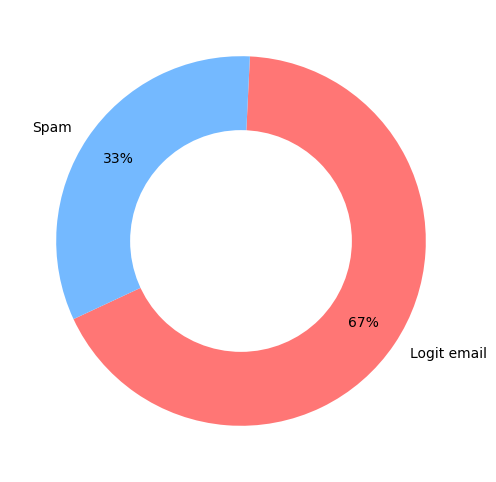

In [33]:
explode = (0.05, 0.05)


plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors=['#ff7675', '#74b9ff'], 
        startangle=205, textprops={'fontsize':10}, pctdistance=0.8,)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)


plt.show()

# Natural Language Processing

## Text Pre-Processing

In [34]:
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

## Download the NLTK Resources (Tokenizer & Stopwords)

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zeus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zeus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Zeus\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\Zeus\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [38]:
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words 

In [39]:
stop_words = set(stopwords.words('english'))

filtered_words = []
for word in word_tokenize(msg.lower()):
    if not word in stop_words:
        filtered_words.append(word)
        
filtered_words
        

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.']

## Word Stems and Stemming

In [40]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

filtered_words = []
for word in word_tokenize(msg.lower()):
    if not word in stop_words:        
        filtered_words.append(ps.stem(word))
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [41]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      Nobody expects the Spanish Inquisition!'

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

filtered_words = []
for word in word_tokenize(msg.lower()):
    if not word in stop_words and word.isalpha():        
        filtered_words.append(ps.stem(word))
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Emails

In [42]:
cleantext = BeautifulSoup(message, 'html.parser').get_text()
cleantext

'From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002\nReturn-Path: \nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36\n\tfor ; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)\nReceived: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for\n    ; Thu, 22 Aug 2002 12:34:53 +0100\nReceived: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by\n    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002\n    07:35:02 -0400 (EDT)\nDelivered-To: exmh-workers@listman.spamassassin.taint.org\nReceived: from int-mx1.corp.spamassassin.taint.org (int-mx1.corp.spamassassin.taint.org\n    [172.1

## Functions for Email Processing

In [43]:
def clean_message(message, stemmer=PorterStemmer(), 
                  stop_words = set(stopwords.words('english'))):   
    
    
    ps = stemmer

    filtered_words = []
    for word in word_tokenize(message.lower()):
        if not word in stop_words and word.isalpha():
            filtered_words.append(ps.stem(word))

    return filtered_words    

In [44]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [45]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                  stop_words = set(stopwords.words('english'))):
    
    cleantext = BeautifulSoup(message, 'html.parser').get_text()    
    
    ps = stemmer

    filtered_words = []
    for word in word_tokenize(cleantext.lower()):
        if not word in stop_words and word.isalpha():
            filtered_words.append(ps.stem(word))

    return filtered_words 

In [46]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

## Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [47]:
data.iat[2, 2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [48]:
data.at[1,'MESSAGE']

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?ilug@linux.ie%7C17%7C114258\n\n\n\n\n\n-- \n\nIrish Linux Users' Group: ilug@linux.ie\n\nhttp://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.\n\nList maintainer: listmaster@linux.ie\n\n\n"

In [49]:
data.loc[1,'MESSAGE']

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?ilug@linux.ie%7C17%7C114258\n\n\n\n\n\n-- \n\nIrish Linux Users' Group: ilug@linux.ie\n\nhttp://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.\n\nList maintainer: listmaster@linux.ie\n\n\n"

In [50]:
data.iloc[2,2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [51]:
data.iloc[5:11]

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5,1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,1,Help wanted. We are a 14 year old fortune 500...,00007.d8521faf753ff9ee989122f6816f87d7
7,1,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,00008.dfd941deb10f5eed78b1594b131c9266
8,1,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab
9,1,"Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...",00010.445affef4c70feec58f9198cfbc22997
10,1,Cellular Phone Accessories All At Below Wholes...,00011.61816b9ad167657773a427d890d0468e


In [52]:
## Apply cleanng function for the first 3 message
first_message = data.MESSAGE.iloc[0:3]

nested_word_list = first_message.apply(clean_msg_no_html)

word_list = [word for sublist in nested_word_list for word in sublist]

word_list

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email',
 'fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'ch

In [53]:
nested_filtered_words = data['MESSAGE'].apply(clean_msg_no_html)

nested_filtered_words.head()



C:\Users\Zeus\AppData\Local\Temp\ipykernel_7512\2824339089.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleantext = BeautifulSoup(message, 'html.parser').get_text()
C:\Users\Zeus\AppData\Local\Temp\ipykernel_7512\2824339089.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  cleantext = BeautifulSoup(message, 'html.parser').get_text()


DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [54]:
nested_filtered_words.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [55]:
nested_list_ham = nested_filtered_words[data.CATEGORY == 0]
nested_list_spam = nested_filtered_words[data.CATEGORY == 1]

In [56]:
nested_list_ham.shape

(3900,)

In [57]:
nested_list_spam.shape

(1896,)

In [58]:
nested_list_ham.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [59]:
word_list_ham = [word for sublist in nested_list_ham for word in sublist]

normal_words = pd.Series(word_list_ham).value_counts()

print('the total number of words in normal emails in the dataset is:', len(normal_words) )

the total number of words in normal emails in the dataset is: 20815


In [60]:
print('the 10 most common words used in non-spam messages:\n', normal_words.sort_values(ascending = False)[:10])

the 10 most common words used in non-spam messages:
 http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
Name: count, dtype: int64


In [61]:
word_list_spammy = [word for sublist in nested_list_spam for word in sublist]

spammy_words = pd.Series(word_list_spammy).value_counts()

print('the total number of words in spam emails in the dataset is:', len(spammy_words) )

the total number of words in spam emails in the dataset is: 13242


In [62]:
print('the 10 most common words used in spam messages:\n', spammy_words.sort_values(ascending = False)[:10])

the 10 most common words used in spam messages:
 http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
Name: count, dtype: int64


# Creating a Word Cloud

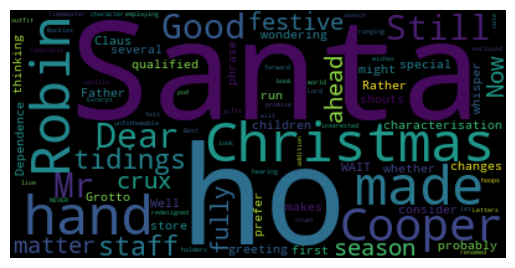

In [63]:
# Create and generate a word cloud image:
word_cloud = WordCloud().generate(email_body)

# Display the generated image:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [64]:
files = nltk.corpus.gutenberg.fileids()
print(files)

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [65]:
example_corpus = gutenberg.words('austen-emma.txt')
len(example_corpus)

192427

In [66]:
example_corpus

['[', 'Emma', 'by', 'Jane', 'Austen', '1816', ']', ...]

In [67]:
novel_as_string = ' '.join(example_corpus)
novel_as_string

'[ Emma by Jane Austen 1816 ] VOLUME I CHAPTER I Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her . She was the youngest of the two daughters of a most affectionate , indulgent father ; and had , in consequence of her sister \' s marriage , been mistress of his house from a very early period . Her mother had died too long ago for her to have more than an indistinct remembrance of her caresses ; and her place had been supplied by an excellent woman as governess , who had fallen little short of a mother in affection . Sixteen years had Miss Taylor been in Mr . Woodhouse \' s family , less as a governess than a friend , very fond of both daughters , but particularly of Emma . Between _them_ it was more the intimacy of sisters . Even before Miss Taylor had ceased to hold the nominal office of go

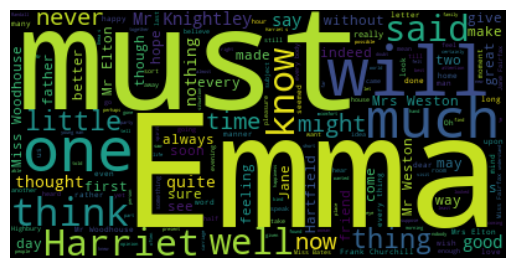

In [68]:
# Create and generate a word cloud image:
word_cloud = WordCloud().generate(novel_as_string)

# Display the generated image:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

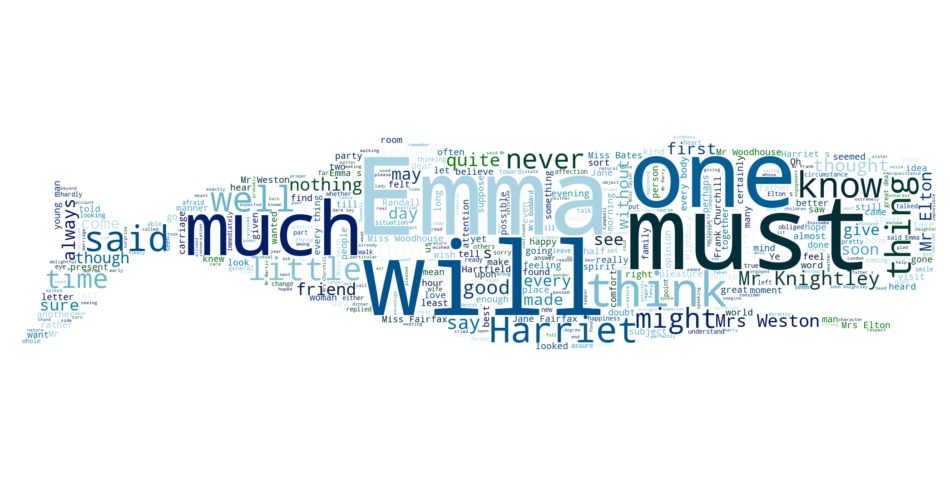

In [69]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=400, colormap='ocean')
word_cloud.generate(novel_as_string)

plt.figure(figsize=[12, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [70]:
rgb_array.shape

(1024, 2048, 3)

In [71]:
rgb_array[512, 512]

array([0, 0, 0], dtype=uint8)

In [72]:
rgb_array[1022, 10]

array([255, 255, 255], dtype=uint8)

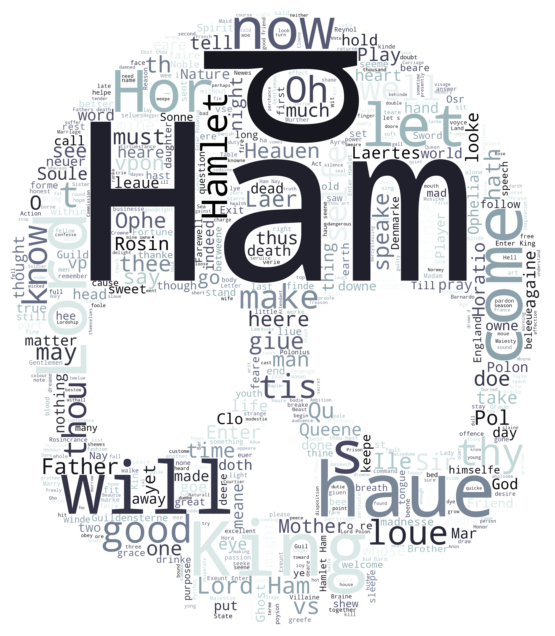

In [73]:
#  use the skull image in the lesson resources to create a word cloud
# for Shakespeare's play Hamlet
example_corpus = gutenberg.words('shakespeare-hamlet.txt')
hamlet_as_string = ' '.join(example_corpus)

icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=600, colormap='bone')
word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[12, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word Cloud of Ham and Spam Messages

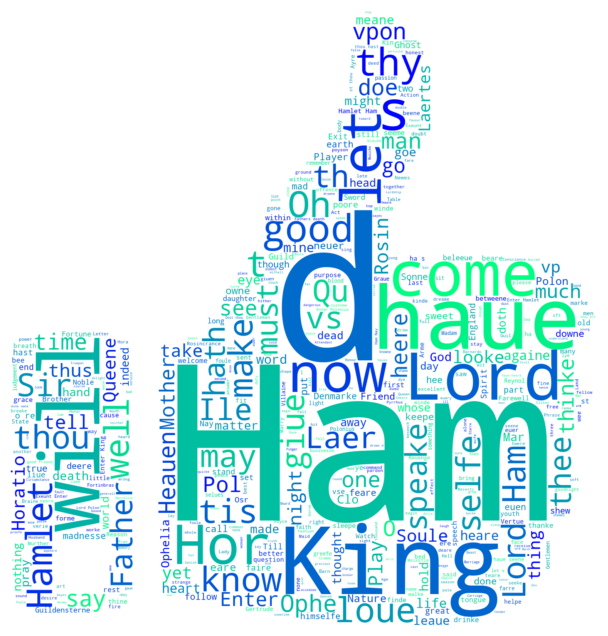

In [74]:
ham_as_string = ' '.join(word_list_ham)

icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='winter')
word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[12, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

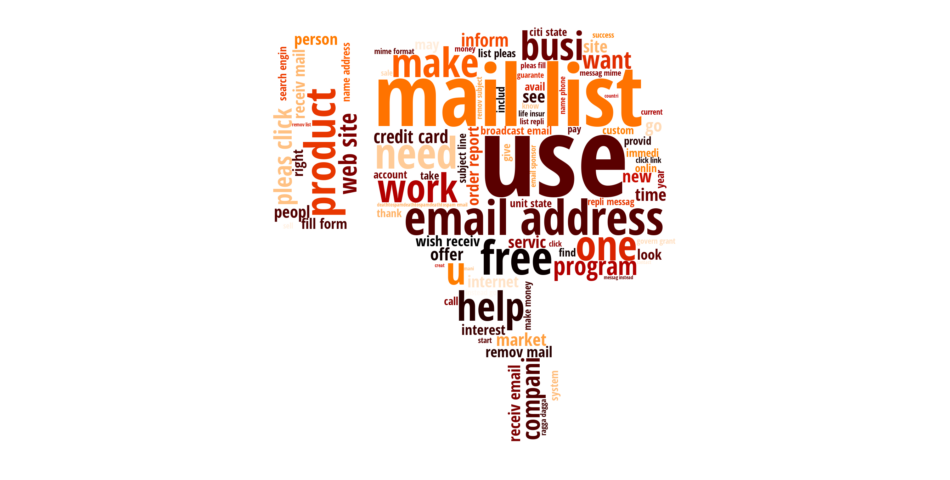

In [75]:
spam_as_string = ' '.join(word_list_spammy)

icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)
word_cloud.generate(spam_as_string)

plt.figure(figsize=[12, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [76]:
filtered_words = [word for sublist in nested_filtered_words for word in sublist]

unique_words = pd.Series(filtered_words).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
Name: count, dtype: int64

In [77]:
#  Create subset of the series called 'frequent_words' that only contains
# the most common 2,500 words out of the total. Print out the top 10 words
frequent_words = unique_words[0:2500]

print('the top 10 unique word is: \n', frequent_words.sort_values(ascending=False)[:10])

the top 10 unique word is: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
Name: count, dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [78]:
word_Id = range(0, len(frequent_words))

vocab = pd.DataFrame({'VOCAB_WORD':frequent_words.index}, index=word_Id, )
vocab.index.name = 'WORD_ID'


vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


# Save the Vocabulary as a CSV File

In [79]:
data.to_csv(DATA_JSON_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Checking if a Word is Part of the Vocabulary

In [80]:
# Challenge: Write a line of code that checks if a particular word is part 
# of the vocabulary. Your code should return True if the word is among the 
# 2,500 words that comprise the vocabulary, and False otherwise. Check these words:
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'
# 'app'
# 'brewery'

In [81]:
word_list_check = ['machine', 'learning', 'fun', 'learn', 'data', 'science', 'app', 'brewery']

for word in word_list_check:
    if word in set(vocab.VOCAB_WORD):
        print(f'{word} is part of the vocabulary')
    else:
        print(f'{word} does not exit in the vocabulary')


machine does not exit in the vocabulary
learning does not exit in the vocabulary
fun is part of the vocabulary
learn is part of the vocabulary
data is part of the vocabulary
science does not exit in the vocabulary
app is part of the vocabulary
brewery does not exit in the vocabulary


# Exercise: Find the Email with the Most Number of Words

In [82]:
# Challenge: Print out the number of words in the longest email (after cleaning & stemming).
# Note the longest email's position in the list of cleaned emails. Print out the stemmed
# list of words in the longest email. Print out the longest email from the data dataframe.

# Hint: use the len() function and practice list comprehension



In [83]:
nested_filtered_words

email_lenght = [len(email) for email in nested_filtered_words]
print("number of words in the longest email is:", max(email_lenght))
print('the longest email\'s position in the list of cleaned emails is:', pd.Series(email_lenght).idxmax())
print('list of words in the longest email is:\n', nested_filtered_words[pd.Series(email_lenght).idxmax()])



number of words in the longest email is: 7671
the longest email's position in the list of cleaned emails is: 5775
list of words in the longest email is:
 ['yahoo', 'group', 'sponsor', 'dvd', 'free', 'p', 'join', 'http', 'new', 'version', 'unison', 'avail', 'test', 'incorpor', 'sever', 'small', 'improv', 'main', 'chang', 'fix', 'bug', 'potenti', 'seriou', 'safeti', 'consequ', 'small', 'number', 'user', 'habit', 'run', 'one', 'instanc', 'unison', 'time', 'parallel', 'user', 'strongli', 'encourag', 'upgrad', 'other', 'wait', 'wish', 'releas', 'includ', 'execut', 'linux', 'solari', 'window', 'look', 'maintain', 'moment', 'none', 'activ', 'develop', 'regularli', 'use', 'unison', 'window', 'machin', 'configur', 'properli', 'build', 'execut', 'export', 'grab', 'http', 'enjoy', 'benjamin', 'chang', 'sinc', 'ad', 'prefer', 'maxthread', 'use', 'limit', 'number', 'simultan', 'file', 'transfer', 'ad', 'backupdir', 'prefer', 'control', 'backup', 'file', 'store', 'basic', 'support', 'ad', 'osx', 'pa

# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [84]:
type(nested_filtered_words)

pandas.core.series.Series

In [85]:
type(nested_filtered_words.tolist())

list

In [86]:
len(nested_filtered_words)

5796

In [87]:
word_columns_df = pd.DataFrame(nested_filtered_words.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [88]:
word_columns_df.shape

(5796, 7671)

### Splitting the Data into a Training and Testing Dataset

In [89]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [90]:
print('Nr of training samples:', X_train.shape[0])
print('Fraction of training set: ', X_train.shape[0]/word_columns_df.shape[0])

Nr of training samples: 4057
Fraction of training set:  0.6999654934437544


In [91]:
X_train.index.name =  X_test.index.name  = 'DOC_ID'

In [92]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [93]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [94]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index[3]

'email'

In [95]:
word_index.get_loc('thu')

393

In [96]:
def make_sparse_matrix(df, indexed_words, labels):
    
    nr_rows = df.shape[0]
    nr_columns = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_columns):
            if df.iat[i,j] in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(df.iat[i,j])               
                category = labels.at[doc_id]
                
                item = {'DOC_ID':doc_id,
                       'LABEL':category,
                       'OCCURENCE':1,
                       'WORD_ID':word_id}
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)          

In [97]:
%%time

sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: total: 20min 24s
Wall time: 20min 25s


In [98]:
sparse_train_df[:5]

,DOC_ID,LABEL,OCCURENCE,WORD_ID
0,4844,0,1,265
1,4844,0,1,1243
2,4844,0,1,502
3,4844,0,1,308
4,4844,0,1,254


In [99]:
sparse_train_df.shape

(429241, 4)

### Combine Occurrences with the Pandas groupby() Method

In [100]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [101]:
vocab.at[3, 'VOCAB_WORD']

'email'

In [102]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [103]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [104]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
258355,5795,2035,0,2
258356,5795,2040,0,1
258357,5795,2272,0,1
258358,5795,2342,0,1
258359,5795,2370,0,1


In [105]:
vocab.at[1923, 'VOCAB_WORD']

'mh'

In [106]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

In [107]:
train_grouped.shape

(258360, 4)

### Save Training Data as .txt File

In [108]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [109]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [110]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,interest,alway,wonder,thing,bad,exampl,goto,languag,support,goto,...,None,None,None,None,None,None,None,None,None,None
4220,url,http,date,final,gdc,europ,review,confernec,session,ect,...,None,None,None,None,None,None,None,None,None,None
2484,stephen,william,mailto,swilliam,weaken,food,transact,argument,note,neighborhood,...,None,None,None,None,None,None,None,None,None,None
2418,el,mon,sep,bitbitch,wrote,eugen,mani,homo,friend,lover,...,None,None,None,None,None,None,None,None,None,None
5110,music,school,joke,american,conductor,european,conductor,talk,european,conductor,...,None,None,None,None,None,None,None,None,None,None


In [111]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [112]:
X_test.shape

(1739, 7671)

In [113]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: total: 8min 17s
Wall time: 8min 17s


In [114]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [115]:
test_grouped.shape

(117776, 4)

In [116]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

In [117]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [118]:
len(test_doc_ids)

1724

In [119]:
len(X_test)

1739

In [120]:
set(X_test.index.values) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [121]:
data.MESSAGE[134]

'------=_NextPart_000_00E8_85C13B1D.B7243B86\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPGh0bWw+DQoNCjxib2R5IGJnY29sb3I9IiNGRkZGRkYiIHRleHQ9IiMwMDAw\n\nMDAiPiANCjxwIGFsaWduPSJjZW50ZXIiPjxhIGhyZWY9Imh0dHA6Ly93d3cu\n\nZGlyZWN0d2Vic3RvcmUuY29tL3RveXMvaW5kZXguaHRtbCI+PGltZyBzcmM9\n\nImh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL21waWMuanBnIiB3aWR0\n\naD0iNTAwIiBoZWlnaHQ9IjMzOSIgYm9yZGVyPSIwIj48L2E+PGJyPiANCjxm\n\nb250IHNpemU9IjMiIGZhY2U9IkFyaWFsLCBIZWx2ZXRpY2EsIHNhbnMtc2Vy\n\naWYiPjxhIGhyZWY9Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL3Rv\n\neXMvaW5kZXguaHRtbCI+PGI+RU5URVIgDQpOT1cgaWYgeW91IGFyZSAxOCBh\n\nbmQgb3ZlcjwvYj48L2E+PC9mb250PjwvcD4gDQo8cCBhbGlnbj0iY2VudGVy\n\nIj48Zm9udCBmYWNlPSJBcmlhbCwgSGVsdmV0aWNhLCBzYW5zLXNlcmlmIiBz\n\naXplPSI0IiBjb2xvcj0iI0ZGMDAwMCI+PGI+U1BFQ0lBTCANCk9GRkVSPGJy\n\nPiANCjxmb250IHNpemU9IjUiPjMwIERheXMgPGk+RlJFRSBhY2Nlc3M8L2k+\n\nIDwvZm9udD48YnI+IA0KdG8gdGhlIGxhcmdlc3QgQWR1bHRzaXRlIG9uIHRo\n\nZSB3ZWIuPGJyPiANCjwvYj4gPG